# 1. 강의영상 

{{<video https://youtu.be/playlist?list=PLQqh36zP38-xFzPZja1CacdZIpcYBNrfO&si=4I4-hymlHlQjTWuy >}}

# 2. Imports 

In [276]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.tree
import sklearn.ensemble
#---#
import warnings
warnings.filterwarnings('ignore')
#---#
import matplotlib.animation
import IPython

# 3. Data + 의사결정나무로 적합

In [4]:
np.random.seed(43052)
temp = pd.read_csv('https://raw.githubusercontent.com/guebin/DV2022/master/posts/temp.csv').iloc[:,3].to_numpy()[:80]
temp.sort()
eps = np.random.randn(80)*3 # 오차
icecream_sales = 20 + temp * 2.5 + eps 
df_train = pd.DataFrame({'temp':temp,'sales':icecream_sales})
df_train

,temp,sales
0,-4.1,10.900261
1,-3.7,14.002524
2,-3.0,15.928335
3,-1.3,17.673681
4,-0.5,19.463362
...,...,...
75,9.7,50.813741
76,10.3,42.304739
77,10.6,45.662019
78,12.1,48.739157


In [7]:
# step1 
X = df_train[['temp']]
y = df_train['sales']
# step2 
predictr = sklearn.tree.DecisionTreeRegressor()
# step3
predictr.fit(X,y)
# step4 -- pass

DecisionTreeRegressor()

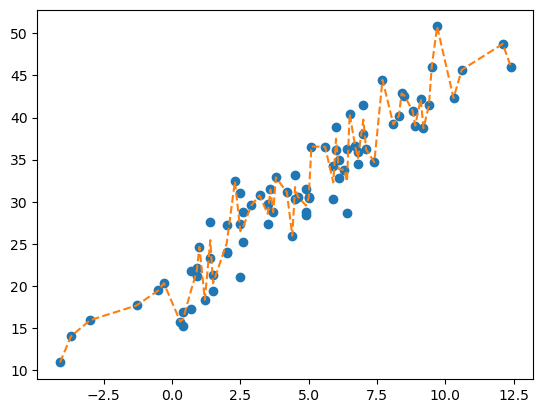

In [10]:
plt.plot(X,y,'o')
plt.plot(X,predictr.predict(X),'--')

# 4. 배깅으로 적합 

In [275]:
# step1 
X = df_train[['temp']]
y = df_train['sales']
# step2 
predictr = sklearn.ensemble.BaggingRegressor()
# step3
predictr.fit(X,y)
# step4 -- pass

BaggingRegressor()

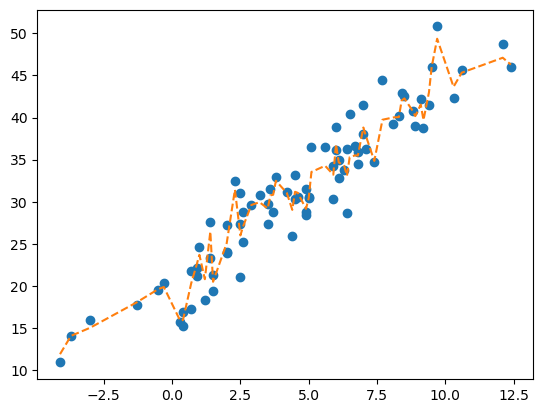

In [14]:
plt.plot(X,y,'o')
plt.plot(X,predictr.predict(X),'--')

# 5. 코드뜯어보기

## A. 원리 

`-` 알고리즘 

1. 80개의 샘플에서 80개를 중복을 허용하여 뽑는다. 
2. 1에서 뽑힌 샘플들을 이용하여 tree를 적합시킨다. 
3. 1-2를 10번 반복하고 10개의 tree의 평균값을 `yhat`으로 선택한다. 

## B. `plot_tree` 체크

`-` 10개의 트리들의 리스트 

In [30]:
trees = predictr.estimators_
trees

[DecisionTreeRegressor(random_state=1644635363),
 DecisionTreeRegressor(random_state=1304269235),
 DecisionTreeRegressor(random_state=1794000214),
 DecisionTreeRegressor(random_state=1273087880),
 DecisionTreeRegressor(random_state=995922005),
 DecisionTreeRegressor(random_state=1372517728),
 DecisionTreeRegressor(random_state=1087222928),
 DecisionTreeRegressor(random_state=3687756),
 DecisionTreeRegressor(random_state=1772778467),
 DecisionTreeRegressor(random_state=92158766)]

`-` 재표본데이터셋 

In [39]:
predictr.estimators_samples_[0] # (X,y)의 쌍을 80개 중복을 허용하여 뽑기 위한 인덱스

array([19, 10, 25, 29, 50,  7, 46, 31, 10, 39, 78, 14, 54, 79, 28, 35, 73,
        0, 74, 72, 66, 36, 55, 24, 41, 11, 68, 65, 71, 36, 54, 41, 76, 34,
        0, 59,  5,  7, 67, 61, 64, 21, 27, 26, 43, 55, 49, 23, 29, 27, 41,
       14, 58,  5, 12, 40, 12, 38,  8, 19, 63,  4, 35, 75, 64,  9, 69, 17,
       32, 15, 60, 55, 18, 55, 22, 73, 28, 48, 57, 63])

In [41]:
samples = predictr.estimators_samples_

`-` 첫번째 트리 재현

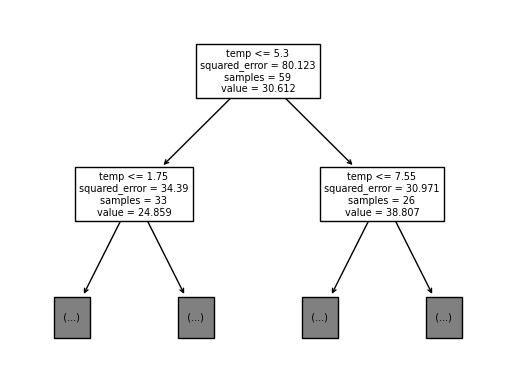

In [50]:
sklearn.tree.plot_tree(
    predictr.estimators_[0],
    feature_names=X.columns,
    max_depth=1
);

In [54]:
X_array = np.array(X)
y_array = np.array(y)

In [63]:
tree = sklearn.tree.DecisionTreeRegressor()
tree.fit(X_array[samples[0]],y_array[samples[0]])

DecisionTreeRegressor()

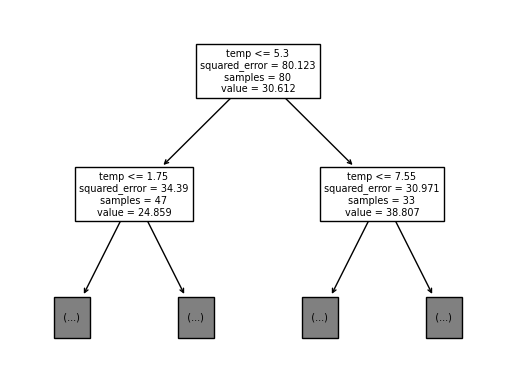

In [64]:
sklearn.tree.plot_tree(
    tree,
    feature_names=X.columns,
    max_depth=1
);

`-` tree 비교 (고정된 $i$)

Text(0.5, 1.0, 'my_tree')

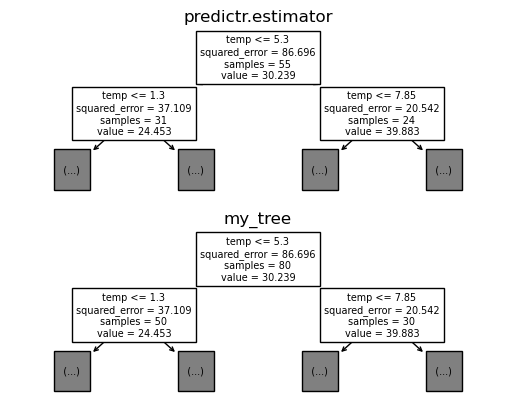

In [73]:
i=4
fig, ax = plt.subplots(2,1)
#---#
sklearn.tree.plot_tree(
    predictr.estimators_[i],
    feature_names=X.columns,
    max_depth=1,
    ax=ax[0]
)
ax[0].set_title('predictr.estimator')
#---#
my_tree = sklearn.tree.DecisionTreeRegressor()
my_tree.fit(X_array[samples[i]],y_array[samples[i]])
sklearn.tree.plot_tree(
    my_tree,
    feature_names=X.columns,
    max_depth=1,
    ax=ax[1]
);
ax[1].set_title('my_tree')

`-` tree 비교 (애니메이션)

In [77]:
fig, ax = plt.subplots(2,1)
plt.close()
#---#
def func(i):
    ax[0].clear()
    sklearn.tree.plot_tree(
        predictr.estimators_[i],
        feature_names=X.columns,
        max_depth=1,
        ax=ax[0]
    )
    ax[0].set_title('predictr.estimator')
    #---#
    ax[1].clear()
    my_tree = sklearn.tree.DecisionTreeRegressor()
    my_tree.fit(X_array[samples[i]],y_array[samples[i]])
    sklearn.tree.plot_tree(
        my_tree,
        feature_names=X.columns,
        max_depth=1,
        ax=ax[1]
    );
    ax[1].set_title('my_tree')
#---#
ani = matplotlib.animation.FuncAnimation(fig,func,frames=10)
display(IPython.display.HTML(ani.to_jshtml()))

## C. ReSampling + Fit 

`-` 고정된 $i$

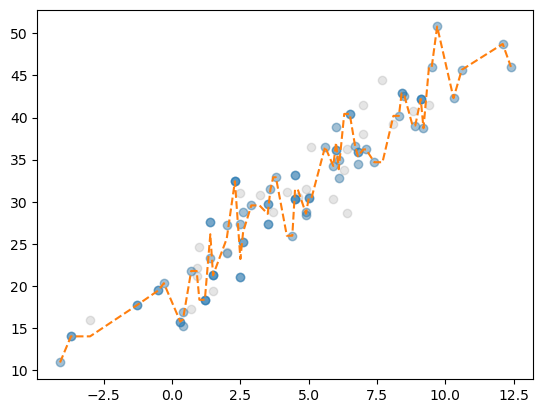

In [102]:
i=4
plt.plot(X,y,'o',alpha=0.2,color='gray')
plt.plot(X_array[samples[i]],y_array[samples[i]],'o',alpha=1/3)
plt.plot(X,trees[i].predict(X),'--')

`-` 애니매이션 

In [109]:
#---#
fig = plt.figure()
ax = fig.gca() 
plt.close()
#---#
def func(i):
    ax.clear()
    ax.plot(X,y,'o',alpha=0.2,color='gray')
    ax.plot(X_array[samples[i]],y_array[samples[i]],'o',alpha=1/3)
    ax.plot(X,trees[i].predict(X),'--')
#---#
ani = matplotlib.animation.FuncAnimation(fig,func,frames=10)
display(IPython.display.HTML(ani.to_jshtml()))

## D. 앙상블결과 재현

`-` 최종결과물 (손으로..)

In [111]:
predictr.predict(X)

array([11.88782962, 14.05941305, 15.02231867, 18.03161729, 19.62619066,
       19.86214551, 15.84293717, 15.95940294, 15.95940294, 20.30137042,
       20.30137042, 22.51278676, 22.51278676, 23.68899036, 20.7954938 ,
       26.45727462, 26.45727462, 20.48421278, 20.48421278, 25.08188452,
       25.08188452, 25.08188452, 31.42611771, 25.99393577, 25.99393577,
       25.99393577, 27.05912187, 27.05912187, 29.60439358, 29.94005816,
       29.18760881, 29.18760881, 30.75340115, 30.82608162, 32.48384789,
       31.03678302, 29.02978839, 31.17487146, 31.17487146, 31.05349512,
       29.147739  , 29.147739  , 29.147739  , 30.40843883, 30.40843883,
       33.53154643, 34.26668831, 33.20982041, 33.20982041, 36.82818648,
       36.82818648, 34.66545508, 34.66545508, 34.24047203, 33.0829342 ,
       33.0829342 , 35.29894866, 35.50366771, 35.47938512, 35.47938512,
       38.8116606 , 38.8116606 , 37.74794717, 34.84063828, 39.73515434,
       40.01130524, 40.05274675, 41.9980937 , 42.26869452, 40.81

In [118]:
np.stack([tree.predict(X) for tree in predictr.estimators_]).mean(axis=0)

array([11.88782962, 14.05941305, 15.02231867, 18.03161729, 19.62619066,
       19.86214551, 15.84293717, 15.95940294, 15.95940294, 20.30137042,
       20.30137042, 22.51278676, 22.51278676, 23.68899036, 20.7954938 ,
       26.45727462, 26.45727462, 20.48421278, 20.48421278, 25.08188452,
       25.08188452, 25.08188452, 31.42611771, 25.99393577, 25.99393577,
       25.99393577, 27.05912187, 27.05912187, 29.60439358, 29.94005816,
       29.18760881, 29.18760881, 30.75340115, 30.82608162, 32.48384789,
       31.03678302, 29.02978839, 31.17487146, 31.17487146, 31.05349512,
       29.147739  , 29.147739  , 29.147739  , 30.40843883, 30.40843883,
       33.53154643, 34.26668831, 33.20982041, 33.20982041, 36.82818648,
       36.82818648, 34.66545508, 34.66545508, 34.24047203, 33.0829342 ,
       33.0829342 , 35.29894866, 35.50366771, 35.47938512, 35.47938512,
       38.8116606 , 38.8116606 , 37.74794717, 34.84063828, 39.73515434,
       40.01130524, 40.05274675, 41.9980937 , 42.26869452, 40.81

`-` 최종결과물 (코드로 정리)

In [235]:
def ensemble(trees,i=None):
    if i is None:
        i = len(trees)
    else: 
        i = i+1
    yhat = np.stack([tree.predict(X) for tree in trees[:i]]).mean(axis=0)
    return yhat

In [244]:
ensemble(trees,0) # 0번트리만 적용

array([10.90026146, 10.90026146, 10.90026146, 19.46336233, 19.46336233,
       20.31785349, 16.3076088 , 16.3076088 , 16.3076088 , 20.27763408,
       20.27763408, 21.52796629, 21.52796629, 21.52796629, 18.34698175,
       27.5369675 , 27.5369675 , 20.30881248, 20.30881248, 25.04963215,
       25.04963215, 25.04963215, 32.42440294, 26.49340711, 26.49340711,
       26.49340711, 26.40925726, 26.40925726, 29.55903213, 30.75418385,
       29.70592592, 29.70592592, 31.45007539, 32.89828946, 32.89828946,
       31.12503261, 25.9552363 , 33.12203011, 33.12203011, 30.60313283,
       29.45886461, 29.45886461, 29.45886461, 30.60789344, 30.60789344,
       30.60789344, 36.5245913 , 34.24458444, 34.24458444, 37.4829917 ,
       37.4829917 , 37.4829917 , 37.4829917 , 31.13974993, 31.13974993,
       31.13974993, 31.13974993, 36.58400962, 35.1723381 , 35.1723381 ,
       39.75311187, 39.75311187, 39.75311187, 34.68877582, 44.47780794,
       39.1744058 , 40.19626989, 42.86734269, 42.60143843, 40.80

In [245]:
ensemble(trees,1) # 0번트리,1번트리의 예측값 평균

array([10.90026146, 12.45139248, 12.45139248, 18.56852168, 19.46336233,
       20.31785349, 16.03419127, 16.57964463, 16.57964463, 21.02420483,
       21.02420483, 21.3736233 , 21.3736233 , 23.07741787, 22.94197463,
       27.5369675 , 27.5369675 , 19.83347885, 19.83347885, 26.16305209,
       26.16305209, 26.16305209, 32.42440294, 28.7554569 , 28.7554569 ,
       28.7554569 , 27.61337612, 27.61337612, 29.55903213, 30.75418385,
       28.54972991, 28.54972991, 31.45007539, 30.82608162, 30.82608162,
       31.66094517, 29.07604701, 32.65944392, 32.65944392, 30.60313283,
       29.40787056, 29.40787056, 29.40787056, 30.5566788 , 30.5566788 ,
       33.57934676, 36.5245913 , 35.63234869, 35.63234869, 37.25155232,
       37.25155232, 35.85263528, 35.85263528, 32.46466946, 33.6755663 ,
       33.6755663 , 35.78403852, 35.87817386, 35.1723381 , 35.1723381 ,
       40.62427057, 40.62427057, 40.62427057, 34.68877582, 44.47780794,
       41.82610687, 40.50051831, 41.83605471, 41.70310258, 40.80

## E. 학습과정 시각화 

`-` 고정된 $i$

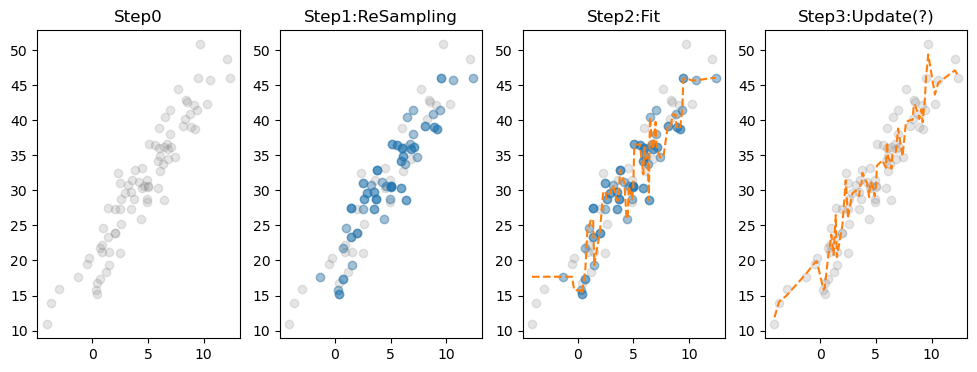

In [263]:
i=9
fig,ax = plt.subplots(1,4,figsize=(12,4))
#--#
ax[0].set_title("Step0")
ax[0].plot(X,y,'o',color='gray',alpha=0.2)
#--#
ax[1].set_title("Step1:ReSampling")
ax[1].plot(X,y,'o',color='gray',alpha=0.2)
ax[1].plot(X_array[samples[i]],y[samples[i]],'o',alpha=1/3)
#--#
ax[2].set_title("Step2:Fit")
ax[2].plot(X,y,'o',color='gray',alpha=0.2)
ax[2].plot(X_array[samples[i]],y[samples[i]],'o',alpha=1/3)
ax[2].plot(X,trees[i].predict(X),'--')
#--#
ax[3].set_title("Step3:Update(?)")
ax[3].plot(X,y,'o',color='gray',alpha=0.2)
ax[3].plot(X,ensemble(trees,i),'--',color='C1')

`-` 애니메이션 

In [270]:
fig,ax = plt.subplots(1,4,figsize=(12,4))
fig.set_dpi(200)
plt.close()
#---#
def func(i):
    for a in ax:
        a.clear()
    #--#
    ax[0].set_title("Step0")
    ax[0].plot(X,y,'o',color='gray',alpha=0.2)
    #--#
    ax[1].set_title("Step1:ReSampling")
    ax[1].plot(X,y,'o',color='gray',alpha=0.2)
    ax[1].plot(X_array[samples[i]],y[samples[i]],'o',alpha=1/3)
    #--#
    ax[2].set_title("Step2:Fit")
    ax[2].plot(X,y,'o',color='gray',alpha=0.2)
    ax[2].plot(X_array[samples[i]],y[samples[i]],'o',alpha=1/3)
    ax[2].plot(X,trees[i].predict(X),'--')
    #--#
    ax[3].set_title("Step3:Update(?)")
    ax[3].plot(X,y,'o',color='gray',alpha=0.2)
    ax[3].plot(X,ensemble(trees,i),'--',color='C1')
#---#
ani = matplotlib.animation.FuncAnimation(fig,func,frames=10)
display(IPython.display.HTML(ani.to_jshtml()))

# 6. Discussion 

`-` 이런 방법을 생각한 근거? 부스트랩